## Project 4: Analysis of Job Market

### Notebook 02: Data Cleaning & Exploratory Data Analysis

The goal of this project is to answer the following questions:

Identify the factors that have the most affect on salary?
Identify the key skills and buzzwords across job category / title?

For the analysis, I have gathered data from the job search engine site SEEK Limited AU. I have limited the study to data related fields like data scientist, data analyst for Sydney and Melbourne.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import pdb
from itertools import product

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Read the data

In [2]:
Total_jobs = pd.read_csv('total_jobs.csv')

In [3]:
Total_jobs.shape

(7442, 13)

In [4]:
Total_jobs.drop(columns=['Unnamed: 0','rating'], axis = 1, inplace=True)

In [5]:
Total_jobs.shape

(7442, 11)

In [6]:
Total_jobs.isnull().sum()

job_title             0
job_location          0
advertiser          167
posted_date           0
salary             4865
type_of_work          0
job_category          0
job_subcategory       0
job_description       0
job_searched          0
url                   0
dtype: int64

In [7]:
Total_jobs['advertiser'].fillna('na', inplace = True)

In [8]:
Total_jobs['job_searched'].value_counts()

data-analyst      7162
data-scientist     280
Name: job_searched, dtype: int64

In [9]:
Total_jobs.job_title.str.lower().str.contains('data scientist').value_counts()

False    7260
True      182
Name: job_title, dtype: int64

In [10]:
Total_jobs[Total_jobs.job_title.str.contains('Data Scientist|Statistician|Big Data|Science')].shape

(264, 11)

In [11]:
## Fill missing values with na
Total_jobs['salary'] = Total_jobs['salary'].fillna('na')
Total_jobs['advertiser'] = Total_jobs['advertiser'].fillna('na')

## Remove duplicate jobs

In [12]:
print('Total jobs scraped: {:,}'.format(Total_jobs.shape[0]))
duplicate_columns = ['job_title','job_location', 'advertiser','salary', 'type_of_work', 'job_description']
Total_jobs = Total_jobs.drop_duplicates(subset= duplicate_columns, keep = 'first')
print('Total Jobs after removing duplicates: {:,}'.format(Total_jobs.shape[0]))

Total jobs scraped: 7,442
Total Jobs after removing duplicates: 5,201


# Observation:
1. Total jobs scraped were 7422, out of which 2,200 were duplicates and removed from the dataframe.
2. More than 60% of salaries were missing. For now, filled the null velaues with na. Further, I will see how to fill the missing values with median or mean.
3. After scraping, there were many jobs which were not directly related to data science, data analysis or data engineering. These were filtered and removed.

## Binning the Job Category:
1. Based on the data, we can see that Information Technology has the most job postings for data related jobs. However the remaining categories have less representation of total jobs. 
2. There are 22 different categories in total with some nearly non-existent. To reduce the dimentionality, I have binned them into 5 groups for better analysis.

In [13]:
Total_jobs['job_category'].value_counts()

Information & Communication Technology    1852
Marketing & Communications                 590
Accounting                                 488
Banking & Financial Services               282
Sales                                      276
Administration & Office Support            207
Manufacturing, Transport & Logistics       151
Healthcare & Medical                       135
Human Resources & Recruitment              124
Consulting & Strategy                      112
Education & Training                       100
Government & Defence                        94
Science & Technology                        93
Retail & Consumer Products                  89
Engineering                                 87
Real Estate & Property                      74
Advertising, Arts & Media                   69
Insurance & Superannuation                  64
Construction                                56
Community Services & Development            55
Call Centre & Customer Service              54
Trades & Serv

In [14]:
def category(x):
    if x in['Information & Communication Technology','Consulting & Strategy',
            'Science & Technology','Call Centre & Customer Service']:
        return 'Information Technology'
    elif  x in ['Accounting','Banking & Financial Services','Insurance & Superannuation',
                'Administration & Office Support','Human Resources & Recruitment',
                'Real Estate & Property','Manufacturing, Transport & Logistics']:
        return 'Financial Services'
    elif  x in ['Government & Defence', 'Healthcare & Medical', 'Education & Training',
                'Mining, Resources & Energy','Engineering','Legal',
                'Trade & Services','Community Services & Development','Hospitality & Tourism']:
        return 'Gov_Services'
    elif x in ['Marketing & Communications','Sales','Retail & Consumer Products','Advertising, Arts & Media']:
        return 'Sales & Marketing'
    else:
        return 'Others'      

In [15]:
Total_jobs['new_job_category'] = Total_jobs['job_category'].map(lambda x: category(x))

In [19]:
Total_jobs['new_job_category'].value_counts()

Information Technology    2111
Financial Services        1390
Sales & Marketing         1024
Gov_Services               531
Others                     145
Name: new_job_category, dtype: int64

In [20]:
x = Total_jobs.loc[786, 'job_title']
word_lst = re.compile("([\w][\w]*'?\w?)").findall(x) ## splitting the string into words using regex
word_lst = [word.lower() for word in word_lst]
print(word_lst)
print(x)

['reporting', 'analyst', 'financial', 'services']
Reporting Analyst - Financial Services


## Filtering Job Titles:

1. There are titles that vary from job to job. Filtering them to get meaningful titles and remove the non related jobs from the data frame.
2. There were 5,200 after duplicates, which brought down to 1248 after filtering and removing non data related jobs.

In [21]:
def redefined_titles(x):
    
    word_lst = re.compile("([\w][\w]*'?\w?)").findall(x) ## splitting the string into words using regex
    word_lst = [word.lower() for word in word_lst]
   
    if any(word in ['head', 'manager'] for word in word_lst) and any(word in ['data','analysis','business intel','bi'] for word in word_lst):
        return 'data manager'
    elif any(word in ['data scientist','statistician','statistics', 'statistical', 'bigdata', 'machine', 'artificial intelligence', 'modelling'] for word in word_lst):
        return 'data scientist'
    elif any(word in ['analy'] for word in word_lst):
        if any(word == 'intelligence' for word in word_lst):
            return 'business intelligence'
        if any(word in ['business', 'bi ', 'insights', 'customer'] for word in word_lst):
            return 'business analyst'
        if any(word == 'data entry' for word in word_lst):
            return None
    elif any(word in ['etl', 'data', 'implementation', 'reporting', 'model'] for word in word_lst):
            return 'data analyst'
    elif any(word in ['business'] for word in word_lst):
        return 'business analyst'
    elif any(word in ['data engineer', 'data migration', 'data governance', 'data modeller'] for word in word_lst ):
        return 'data engineer'
    else:
        return None

In [22]:
Total_jobs['new_job_title'] = Total_jobs['job_title'].map(lambda x : redefined_titles(x))

In [23]:
Total_jobs.new_job_title.value_counts()

data analyst        603
business analyst    548
data manager         81
data scientist       38
Name: new_job_title, dtype: int64

In [24]:
print('Total jobs before filter: {:,}'.format(Total_jobs.shape[0]))
Total_jobs = Total_jobs[~Total_jobs['new_job_title'].isnull()].reset_index(drop=True)
print('Total jobs after filter: {:,}'.format(Total_jobs.shape[0]))

print('\nCounts of redefined Jobs:')
print('------------------------')
print(Total_jobs['new_job_title'].value_counts())

Total jobs before filter: 5,201
Total jobs after filter: 1,270

Counts of redefined Jobs:
------------------------
data analyst        603
business analyst    548
data manager         81
data scientist       38
Name: new_job_title, dtype: int64


In [27]:
Total_jobs['new_job_category'].value_counts()

Information Technology    887
Financial Services        208
Sales & Marketing         111
Gov_Services               52
Others                     12
Name: new_job_category, dtype: int64

## Cleaning, extracting the salary out of description, title and salary column

# Observation:
1. While analysing the data, I came across the salaries mentioned in the job description and job title columns, for which I had to extract.
2. Salaries were given either per hour, per day or annual. I converted all the salaries to annual for better prediction.
3. There were phone numbers that came up in the description which were pulled up while cleaning for which I have given a condition to return None anything above 500 thousand.
4. After extracting salaries from all columns, I see that only 39% of salaries are available.

In [23]:
 def sal_calc(x):      
    x = x.replace('-', ' ')
    x = x.replace('$', ' ')
    x = x.replace(',', '')
    x = x.split(' ')

    kl = ['000k', '000K', '000K+', '000k+', 'k' , 'K' , 'K+', 'k+']
    for i in kl:
        x = [val.replace(i, '000') for val in x]
    x = [int(k) for k in x if k.isdigit()]
    
    if len(x) == 0:
        return None
    else:
        if max(x) <= 110:
            res = 2080*max(x) ## converting hourly rate to yearly
            if res > 500000 or res <= 40000:
                return None
            else:
                return res
            
        elif max(x) > 110 and max(x) <= 1800: ## converting day to yearly
            res = 260*max(x)
            if res > 500000 or res <= 40000:
                return None
            else:
                return res
        else:
            res = max(x)
            if res > 500000 or res <= 40000:
                return None
            return res

In [24]:
Total_jobs['final_salary1'] = Total_jobs['salary'].map(lambda x: sal_calc(x))
Total_jobs['final_salary2'] = Total_jobs['job_title'].map(lambda x: sal_calc(x))
Total_jobs['final_salary3'] = Total_jobs['job_description'].map(lambda x: sal_calc(x))
Total_jobs['final_salary'] = Total_jobs[['final_salary1','final_salary2','final_salary3']].max(axis=1)
Total_jobs = Total_jobs.drop(['final_salary1','final_salary2','final_salary3'], axis=1)

In [25]:
print('Total available salaries:', Total_jobs[~Total_jobs['final_salary'].isnull()].shape[0])
print('Out of total of:', Total_jobs.shape[0])
print('Which means {:.2f}% salaries are available'.format(Total_jobs[~Total_jobs['final_salary'].isnull()].shape[0] / Total_jobs.shape[0] * 100))

Total available salaries: 507
Out of total of: 1270
Which means 39.92% salaries are available


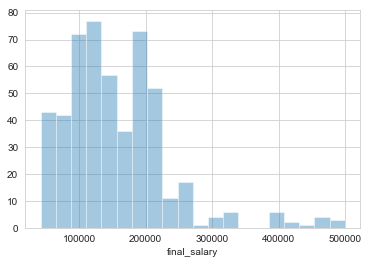

In [26]:
sns.distplot(Total_jobs['final_salary'][Total_jobs['final_salary'].notnull()], kde = False)

## Extracting the experience out of titles:

# Observation:
There was no information present in the data to extract the level of experience. I have given the titles based on the keywords given in description to Junior, Senior and Manager for better analysis.

In [27]:
## Extracting the experince level from titles:

def experience(x):
    x = x.lower()
    if 'junior' in x:
        return 'Junior_level'
    elif 'senior' in x:
        return 'Senior_level'
    elif 'manager' in x or 'head' in x:
        if 'to manager' not in x:
            return 'Senior_level'
    else:
        return 'Mid_level'

In [28]:
Total_jobs['experience_level'] = Total_jobs['job_title'].map(lambda x: experience(x))
Total_jobs['experience_level'].value_counts(dropna = False)

Mid_level       887
Senior_level    357
Junior_level     26
Name: experience_level, dtype: int64

The distributuions seems heavily skewed towards mid level, one reason could be there was no experience level mentioned and the levels given were completely based on the title. This could be otherwise also that a mid-level can also be the same as junior.

## Exploring the data

In [29]:
data = Total_jobs[Total_jobs['final_salary'].notnull()]

In [30]:
data.isnull().sum()

job_title           0
job_location        0
advertiser          0
posted_date         0
salary              0
type_of_work        0
job_category        0
job_subcategory     0
job_description     0
job_searched        0
url                 0
new_job_category    0
new_job_title       0
final_salary        0
experience_level    0
dtype: int64

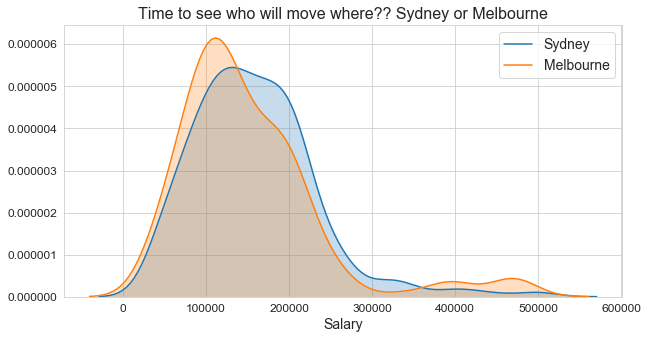

In [31]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
for location in ['Sydney', 'Melbourne']:
    sns.kdeplot(data[data['job_location'].str.contains(location)]['final_salary'], shade = True, ax = ax, label = location)

plt.title('Time to see who will move where?? Sydney or Melbourne', fontsize = 16)
plt.xlabel('Salary', fontsize = 14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Hurray!! No need to change location, as I don't see much difference in the salaries. However, Sydney is sligtly on the higher end compared to Melbourne.

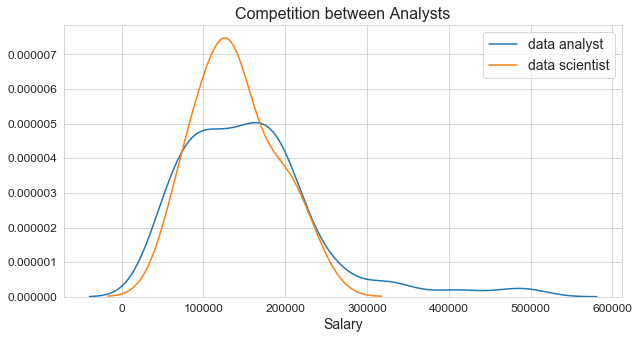

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for job in data['new_job_title'].unique()[:2]:
    sns.kdeplot(data[data['new_job_title']==job]['final_salary'], shade=False, ax=ax, label=job)

plt.title('Competition between Analysts', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Seems like business analysts are slightly on higher end compared to data analyst.

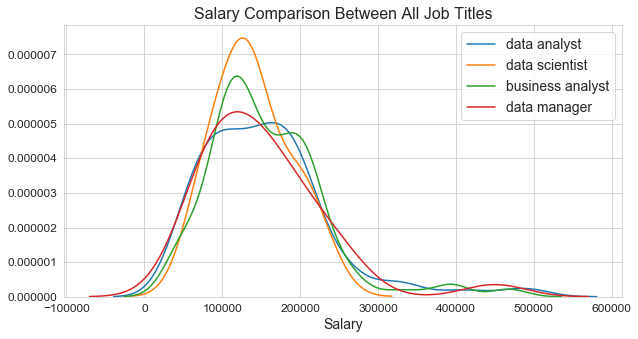

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for title in data['new_job_title'].unique():
    sns.kdeplot(data[data['new_job_title']==title]['final_salary'], shade=0, ax=ax, label=title)

plt.title('Salary Comparison Between All Job Titles', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

The data scientist salaries are not higher compared to other roles, as there were very few observations in my dataframe. Data Analyst, Data Manager, and Business Analyst are paid quite well based on thier experience.

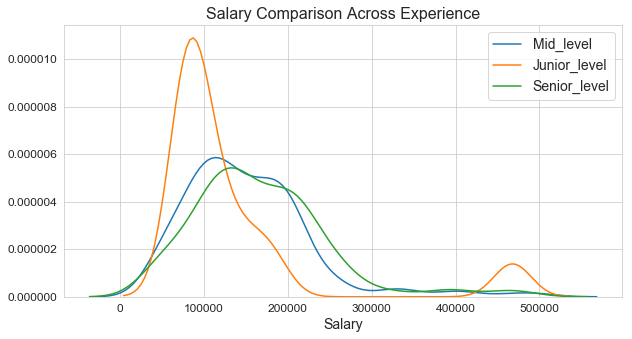

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for exp in data['experience_level'].unique():
    sns.kdeplot(data[Total_jobs['experience_level']==exp]['final_salary'], shade=0, ax=ax, label=exp)

plt.title('Salary Comparison Across Experience', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

There's is no clarity with the job roles and their experience, these are assumed and ranked based on the job description available. I can not draw any conclusions based on this. However, we can see that salary increases based on the seniority

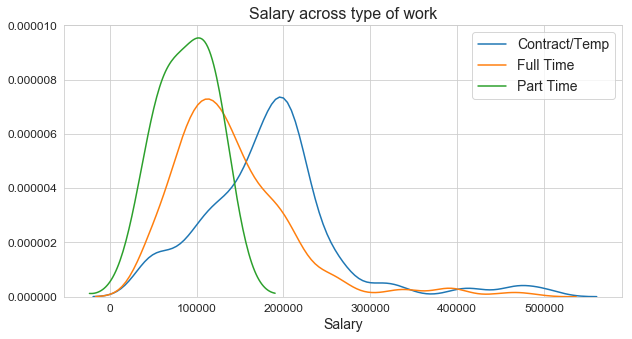

In [35]:
fig, ax  = plt.subplots(1,1, figsize = (10,5))
for work in data['type_of_work'].unique():
    sns.kdeplot(data[data['type_of_work'] == work]['final_salary'], shade = 0, ax = ax, label = work)

plt.title('Salary across type of work', fontsize = 16)
plt.xlabel('Salary', fontsize = 14)
plt.ylabel = ('')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

Contract jobs are paid much higher compared to full time. Part-time jobs are paid much lower.

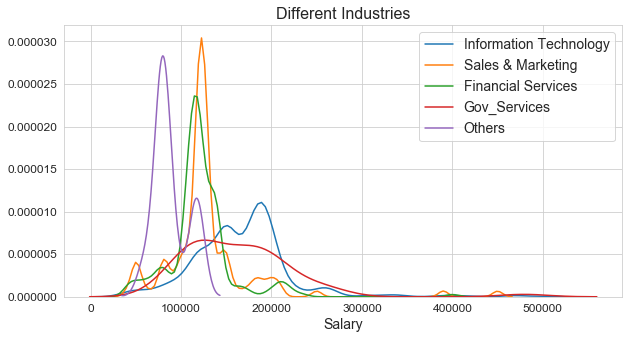

In [49]:
fig, ax  = plt.subplots(1,1, figsize = (10,5))
for category in data['new_job_category'].unique():
    sns.kdeplot(data[data['new_job_category'] == category]['final_salary'], shade = 0, ax = ax, label = category)

plt.title('Different Industries', fontsize = 16)
plt.xlabel('Salary', fontsize = 14)
plt.ylabel = ('')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

## Imputing missing salary:

Most of the salaries are missing from the data available. There are only 39.66% (495) of salaries available out of 1248. The predictions with this data(where most of the salaries are missing) would not be possible. So, I will be imputing the salaries based on the median salaries with respective title and category(industry) available  in the data.
1. Looking for the missing salary data.
2. Using the median salary from unique group of job title, category and work type (contract,full-time,part-time)

In [37]:
## Looking for missing salary information:
missing_data = Total_jobs[Total_jobs['final_salary'].isnull()]

missing_data.isnull().sum()

job_title             0
job_location          0
advertiser            0
posted_date           0
salary                0
type_of_work          0
job_category          0
job_subcategory       0
job_description       0
job_searched          0
url                   0
new_job_category      0
new_job_title         0
final_salary        763
experience_level      0
dtype: int64

In [38]:
print('Results before imputation : {:,} available, {:,} missing'.format(data.shape[0], missing_data.shape[0]))
# trying to impute using title, industry and contract type
for x, y, z in product(Total_jobs['new_job_title'].unique(), Total_jobs['new_job_category'].unique(), Total_jobs['type_of_work'].unique()):
    mask1, mask_1 = missing_data['new_job_title']==x, data['new_job_title']==x
    mask2, mask_2 = missing_data['new_job_category']==y, data['new_job_category']==y
    mask3, mask_3 = missing_data['type_of_work']==z, data['type_of_work']==z
    missing_data.loc[mask1 & mask2 & mask3, 'final_salary'] = data.loc[mask_1 & mask_2 & mask_3, 'final_salary'].median()
    
data = pd.concat([data, missing_data]) # Merging the dataframes after imputation using title, category and type of work

missing_data = data[data['final_salary'].isnull()] # Split dataframe for missing salaries
data = data[data['final_salary'].notnull()]        # Split dataframe for avaliable salaries
print('Results after 1st imputation : {:,} available, {:,} missing'.format(data.shape[0], missing_data.shape[0]))

Results before imputation : 507 available, 763 missing
Results after 1st imputation : 1,262 available, 8 missing


In [39]:
print('Results before imputation : {:,} available, {:,} missing'.format(data.shape[0], missing_data.shape[0]))
# trying to impute using title, and industry)
for x, y in product(Total_jobs['new_job_title'].unique(), Total_jobs['new_job_category'].unique()):
    mask1, mask_1 = missing_data['new_job_title']==x, data['new_job_title']==x
    mask2, mask_2 = missing_data['new_job_category']==y, data['new_job_category']==y
    missing_data.loc[mask1 & mask2, 'final_salary'] = data.loc[mask_1 & mask_2, 'final_salary'].median()

data = pd.concat([data, missing_data]) # Merging the dataframes after imputation using title and category(industry)

missing_data = data[data['final_salary'].isnull()] # Split dataframe for missing salaries
data = data[data['final_salary'].notnull()]        # Split dataframe for avaliable salaries
print('Results after 2nd imputation : {:,} available, {:,} missing'.format(data.shape[0], missing_data.shape[0]))

Results before imputation : 1,262 available, 8 missing
Results after 2nd imputation : 1,270 available, 0 missing


## Distribution Plots after Imputation:

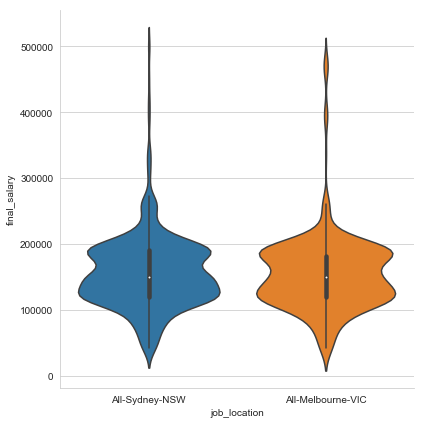

In [40]:
# City comparison
sns.catplot(x="job_location", y="final_salary", kind="violin", data=data, height=6, aspect= 1, )

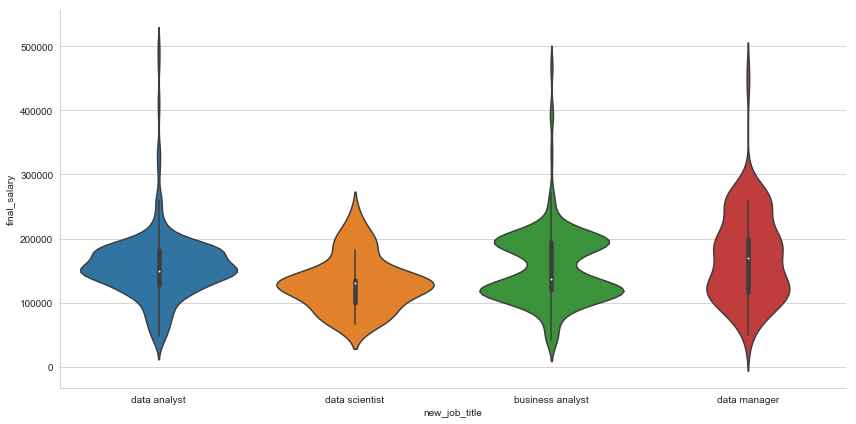

In [41]:
## job title comparision
sns.catplot(x="new_job_title", y="final_salary", kind="violin", data=data, height=6, aspect= 2)

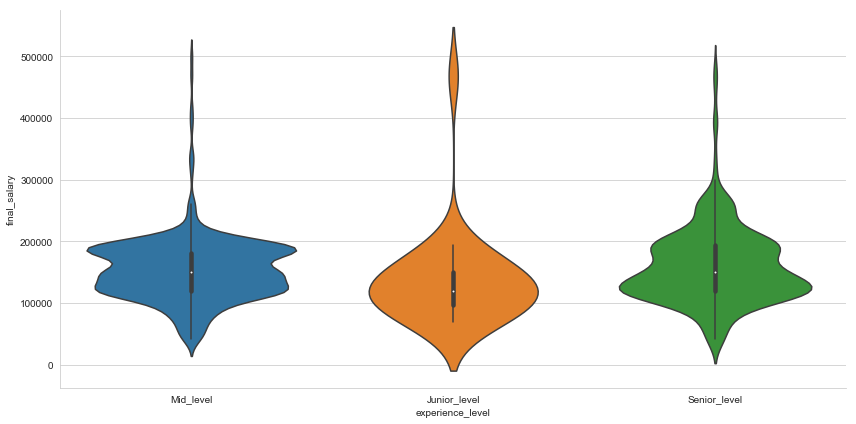

In [42]:
## By experience
sns.catplot(x="experience_level", y="final_salary", kind="violin", data=data, height=6, aspect= 2)

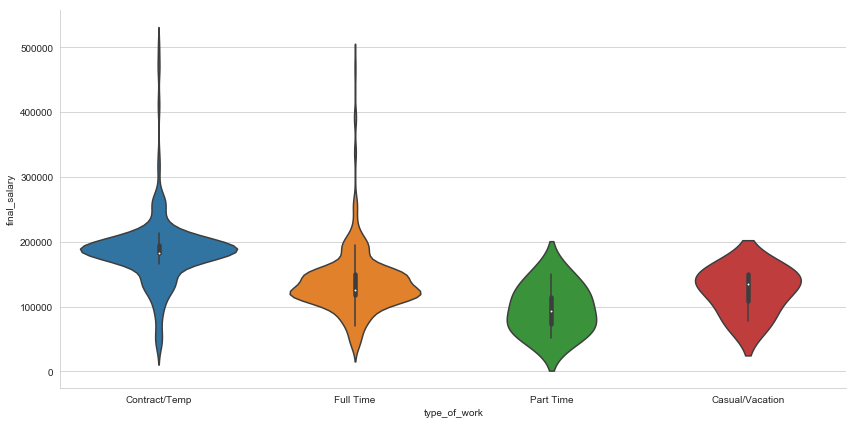

In [43]:
## Type of work
sns.catplot(x="type_of_work", y="final_salary", kind="violin", data=data, height=6, aspect= 2)

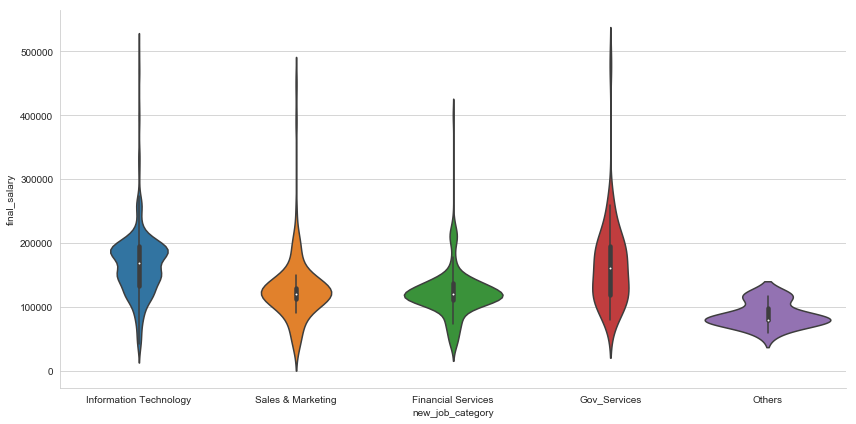

In [44]:
sns.catplot(x="new_job_category", y="final_salary", kind="violin", data=data, height=6, aspect= 2)

# Observation:
After imputing the salaries:
1. Location wise, there's no much difference. Sydney is still on higher end compared to Melbourne.
2. Data Analyst is leading compared to Business Analyst after imputing salaries.
3. Contract/ Temp are paid high and is still leading compared to full time and other work types.
4. Information Technology is leading and this may be because of the higher count of observations available for this category. 

## Baseline Calculation

In [45]:
X = data.drop(['final_salary'], axis = 1)
y = data['final_salary']

In [46]:
baseline = np.mean(y)
print('baseline:' , baseline)

baseline: 155353.87992125985


In [47]:
#moving it to a new csv for modelling
#final_jobs = data.to_csv('final_jobs.csv')

## This notebook covers cleaning the dataset and exploratory analysis. I have created Notebook 3, 4 and 5 which will cover the models for prediction of salaries and job categories.